In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import os
import glob
import plotly.express as px
from scipy.interpolate import griddata
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#import xarray as xr

In [19]:
# this skips first 10 rows and then rows 11 to 14. Had to skip specific rows to get rid of header information
skip = np.arange(0, 11).tolist() + np.arange(12, 15).tolist()

In [22]:
## also skip 13 and 14
mat_code = pd.read_csv('look_up_table.txt', delimiter = '  ', skiprows = skip)
mat_code

/var/folders/rl/0vwydsgj6nx5gmddmc5qtxz00000gn/T/ipykernel_1727/250458132.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  mat_code = pd.read_csv('SZA_Cloudy_Chl0p5_fixed.txt', delimiter = '  ', skiprows = skip)


,thetasun,Ed(air),Eu(air),PAR_Ed(air),PAR_Eo(air),Ed(z=0),Eu(z=0),PAR_Ed(z=0),PAR_Eo(z=0)
0,0.0,116.94000,7.040100,535.3500,1048.3000,112.00000,2.095500,512.0200,626.8500
1,2.0,116.86000,7.043600,534.9800,1048.6000,111.91000,2.094300,511.6300,626.4600
2,4.0,116.62000,7.038400,533.8600,1047.6000,111.67000,2.090100,510.5100,625.2100
3,6.0,116.21000,7.024700,531.9900,1045.3000,111.26000,2.083000,508.6800,623.1100
4,8.0,115.63000,7.002300,529.3800,1041.8000,110.70000,2.073000,506.1200,620.1600
...,...,...,...,...,...,...,...,...,...
229,82.0,8.69280,0.499680,39.7190,83.0700,8.36410,0.170970,38.1570,49.4250
230,84.0,5.89570,0.341090,26.7210,55.9440,5.67580,0.121240,25.6830,33.3480
231,86.0,3.58860,0.209480,16.0680,33.6720,3.45760,0.078444,15.4560,20.1410
232,88.0,1.69650,0.099837,7.5046,15.7340,1.63580,0.039141,7.2245,9.4488


In [20]:
g4_air_sea = pd.read_csv('merged_with_transmission.csv')
g4_air_sea
## can get rid of sun_zen_angle column

,Unnamed: 0.1,Unnamed: 0,time,licor_par,cruise,pop,n_per_uL,c_per_uL,lat,lon,...,diam_med,hour,round_lat,round_lon,scalar,chla_eco,sat_par,sun_zen_angle,new_sun_zen,transmission
0,0,0,2021-11-19 17:00:00+00:00,486.087167,TN397_740,prochloro,59.103647,1.471909,31.047502,-119.963323,...,0.024904,17,31.0,-120.0,5.205841,0.234573,576.539448,64.306618,64.306618,0.569564
1,1,1,2021-11-19 18:00:00+00:00,891.885167,TN397_740,prochloro,73.904420,1.901776,30.962975,-120.109363,...,0.025733,18,31.0,-120.0,5.037268,0.163371,1088.754558,56.584970,56.584970,0.575888
2,2,2,2021-11-19 19:00:00+00:00,1092.274333,TN397_740,prochloro,60.774550,1.420525,30.799496,-120.382978,...,0.023374,19,31.0,-120.5,5.219913,0.107802,1286.427594,51.885782,51.885782,0.580986
3,3,3,2021-11-19 20:00:00+00:00,1002.763667,TN397_740,prochloro,55.664875,1.528290,30.685723,-120.577657,...,0.027455,20,30.5,-120.5,5.233759,0.146960,1217.701810,50.218605,50.218605,0.581575
4,4,4,2021-11-19 21:00:00+00:00,922.692167,TN397_740,prochloro,63.412060,1.730710,30.605379,-120.714316,...,0.027293,21,30.5,-120.5,5.602349,0.139737,1091.592987,53.078498,53.078498,0.580724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,468,468,2021-12-13 18:00:00+00:00,688.223000,TN397_740,prochloro,241.180751,8.157731,14.772220,-152.864218,...,0.033824,18,15.0,-153.0,9.271543,0.077962,1210.487611,71.270990,71.270990,0.579864
469,469,469,2021-12-13 19:00:00+00:00,1092.185333,TN397_740,prochloro,245.492471,8.885463,14.777021,-152.867004,...,0.036194,19,15.0,-153.0,9.141849,0.068782,1266.557619,59.442556,59.442556,0.588324
470,470,470,2021-12-13 20:00:00+00:00,1320.478000,TN397_740,prochloro,244.086001,9.166140,14.812232,-152.894542,...,0.037553,20,15.0,-153.0,9.028236,0.050990,1365.744348,49.127855,49.127855,0.596290
471,471,471,2021-12-13 21:00:00+00:00,1379.093846,TN397_740,prochloro,254.518232,10.394303,14.977258,-153.025971,...,0.040839,21,15.0,-153.0,8.841401,0.037757,1409.942455,41.502097,41.502097,0.601956


In [5]:
g4_data = pd.read_csv('../data/g4_merged_data.csv')
g4_data['sun_zen_angle'].max()
# anythign over 90 degrees, subtract it by 90
g4_data['new_sun_zen'] = 0
angle = np.where(g4_data['sun_zen_angle'] > 90, 180 - g4_data['sun_zen_angle'], g4_data['sun_zen_angle'])
g4_data['new_sun_zen'] = angle
g4_data.loc[g4_data['sun_zen_angle'] > 90]
g4_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
g4_data.time = pd.DatetimeIndex(g4_data.time.values).tz_convert('UTC')
g4_data

FileNotFoundError: [Errno 2] No such file or directory: '../data/g4_merged_data.csv'

## Air-sea transmission calculations

In [ ]:
# read data from merged dataset
merged_par=pd.read_csv('/Users/Kathy/Desktop/UW/seaflow/decomposition_project/data/merged_g4_data.csv')
# fix time
merged_par['time'] = pd.DatetimeIndex(merged_par['time'].apply(lambda x: parse(x))).tz_convert('UTC')
lookup=pd.read_csv('/Users/Kathy/Downloads/sza_cloudy_long.csv')

# calculate air sea transmission
x=lookup['thetasun'] # this is solar zenith
y=lookup['wind_speed'] # this is wind (i think)
z= lookup['PAR_Eo(z=0)']/lookup['PAR_Eo(air)'] # this should probably be the air sea transmission

# create mesh grid
xi=merged_par['new_sun_zen']
yi=merged_par['scalar']
xi,yi = np.meshgrid(xi,yi)

# interpolate the data onto target grid
zi = griddata((x,y),z,(xi,yi),method='linear')


# create plot of interpolated gridded data
fig = plt.figure(figsize=(10,15)) #Make a nice figure!
ax = plt.gca()
 
CS = ax.imshow(zi, 
                extent=[x.min(), x.max(), y.min(), y.max()], 
                aspect=4,
                origin='lower')

ax.plot(xi,yi,color='lightgrey',alpha=0.05,linestyle='',marker='.')

cbar = plt.colorbar(CS, label='Air-Sea Transmission',fraction=0.035, pad=0.04); # add color bar

In [25]:
# assigning variables to columns to be used for interpolation
x = mat_code['thetasun']
y = mat_code['Ed(air)']
v = mat_code.iloc[:, 8] / mat_code.iloc[:, 5]

data_x = g4_data['new_sun_zen']
data_y = g4_data['scalar'] / 1.94384

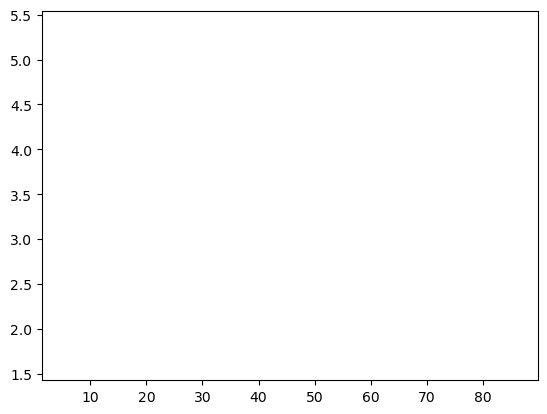

In [26]:
# this creates the grid for interpolation use 
xi,yi = np.meshgrid(data_x, data_y)
zi = griddata((x,y),v,(xi,yi), method = 'linear')
zi
fig = plt.figure()
ax = fig.add_subplot(111)
plt.contourf(xi,yi,zi)

In [ ]:
## this is the actual code that calculates depth integrated PAR at 5m

# grab interpolated air sea transmission vals
merged_par['transmission']=np.diag(zi)
# calculate depth integrated par
kd490 = 0.0166 + (0.0773*(merged_par['chla_eco']**0.6715))
kdPar = 0.0665 + (0.874*(kd490 - 0.00121/kd490))


# Calculate Par at 5m depth
merged_par['5m_par']=merged_par['transmission']*merged_par['sat_par']*np.exp(-kdPar*5)

## Inserted code from Kathy for how she found wind data

In [2]:
# pretty sure this was code to calculate wind data but it might be already in a dataset so ... dont need to call it in here

G4_wind=xr.open_dataset('/Users/Kathy/Desktop/UW/seaflow/decomposition_project/data/G4_ERA5_wind.nc', 
                        decode_times=True)
# calculate magnitude of wind speed from N and E components
# subset by time
G4_timerange=pd.date_range('2021-11-19T00:00:00.000000000',
              '2021-12-16T00:00:00.000000000',freq='H')
G4_time_sub=G4_wind.sel(time=G4_timerange)
# convert to pandas df and subset
G4_wind_mag=G4_time_sub.to_dataframe().reset_index()
G4_scalar_df=G4_wind_mag.drop(columns=['u10','v10']).rename(columns={'longitude':'round_lon',
                                                                     'latitude':'round_lat'})
G4_scalar_df['time'] = pd.DatetimeIndex(G4_scalar_df['time']).tz_localize('UTC')

NameError: name 'xr' is not defined

# Figures for SACNAS poster

## plot for all hourly PAR

NameError: name 'parax' is not defined

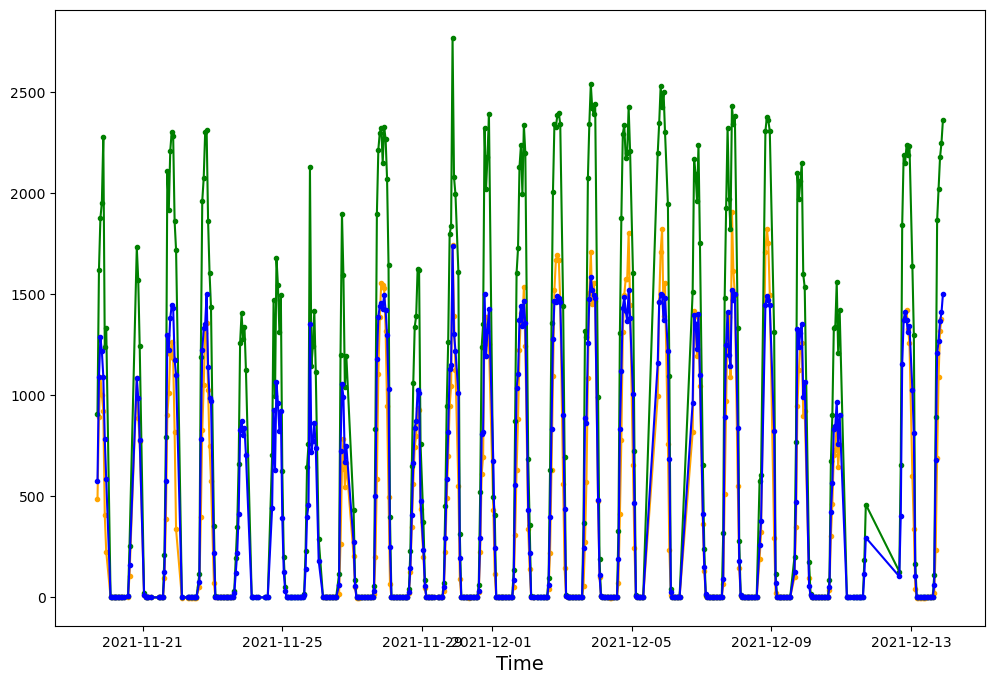

In [28]:
## attempting to make par comparison graph for G4
# setting variables
x = g4_data['time']
y = g4_data['licor_par']
y1 = g4_data['par']
y2 = g4_data['sat_par']

fig, ax = plt.subplots(sharex = True, nrows = 1, ncols = 1, figsize = (12, 8))
# plots carbon quota data
ax.plot(x, y, c='orange', marker = '.', label = 'Licor')
ax.plot(x, y1, c='green', marker = '.', label = 'Ship')
ax.plot(x, y2, c = 'blue', marker = '.', label = 'Satellite')

# makes secondary axis by sharing the the xaxis and creating yaxis
#parax = ax.twinx()
ax.set_xlabel('Time', fontsize = 14)
parax.set_ylabel('par', fontsize = 14)
ax.set_ylabel('PAR (μE/m^2/s)', fontsize = 14)
plt.title('G4 TN397 Licor, Uncalibrated, and Calibrated PAR', fontsize = 15)
ax.legend()

## Plot for hourly uncalib and calib PAR

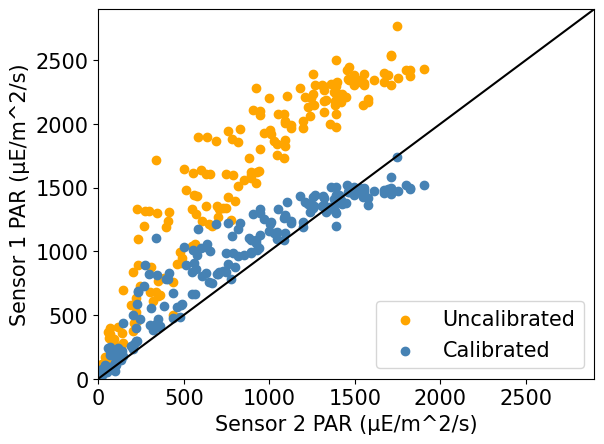

In [83]:
# licor against ship
x = g4_data['licor_par']
y = g4_data['par']
plt.scatter(x, y, color='orange', label = 'Uncalibrated')

# licor against sat
y1 = g4_data['sat_par']
plt.scatter(x, y1, color='steelblue', label = 'Calibrated')
plt.xlabel("Sensor 2 PAR (μE/m^2/s)")
plt.ylabel("Sensor 1 PAR (μE/m^2/s)")
plt.legend()
plt.xlim(0, 2900)
plt.ylim(0, 2900)

x1= np.linspace(0,2900,2900) 
plt.plot(x1,x1,'k-') # identity line
plt.rcParams.update({'font.size':15})

plt.show()

## grouped PAR by daily mean

In [5]:
daily_par = g4_data.groupby([pd.Grouper(key = 'time', freq = 'D')]).agg({'par': 'mean',
                                                                                  'licor_par' : 'mean',
                                                                                  'sat_par' : 'mean'}).reset_index()
daily_par

,time,par,licor_par,sat_par
0,2021-11-19 00:00:00+00:00,1601.576230,718.394976,947.035539
1,2021-11-20 00:00:00+00:00,320.672769,190.675157,201.093199
2,2021-11-21 00:00:00+00:00,857.232692,400.941765,543.023594
3,2021-11-22 00:00:00+00:00,874.393695,431.775832,551.715657
4,2021-11-23 00:00:00+00:00,348.103938,5.244396,219.649724
5,2021-11-24 00:00:00+00:00,658.036948,NaN,412.427923
6,2021-11-25 00:00:00+00:00,399.452145,NaN,250.522807
7,2021-11-26 00:00:00+00:00,431.538393,182.532426,260.516370
8,2021-11-27 00:00:00+00:00,734.507419,413.094394,464.052114
9,2021-11-28 00:00:00+00:00,534.609942,267.270796,335.520806


## Daily Uncalibrated PAR

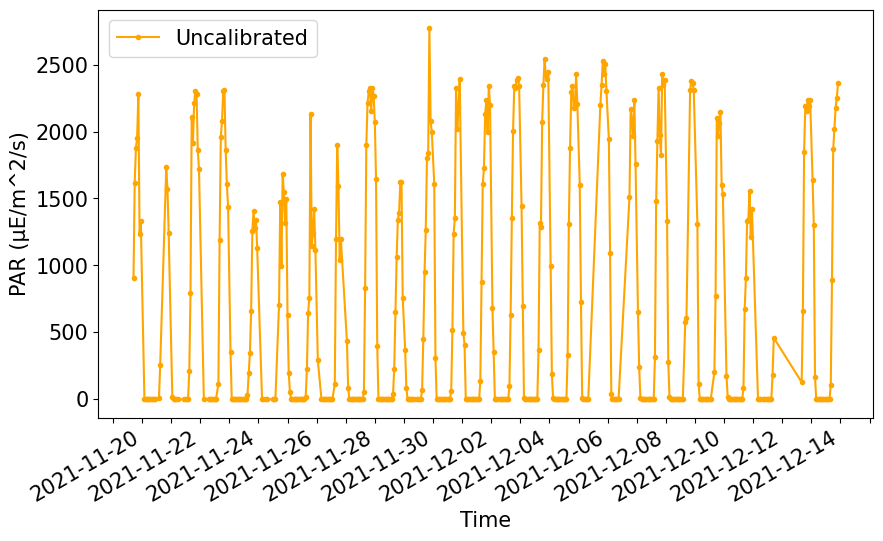

In [69]:
## attempting to make par comparison graph for G4
# setting variables

x = g4_data['time']
y1 = g4_data['par']

fig, axs = plt.subplots(sharex = True, nrows = 1, ncols = 1, figsize = (10, 6))
# plots carbon quota data
#axs.plot(x, y, c='green', marker = '.', label = 'Licor')
axs.plot(x, y1, c='orange', marker = '.', label = 'Uncalibrated')
#axs.plot(x, y2, c = 'blue', marker = '.', label = 'Satellite')

axs.set_xlabel('Time')
axs.set_ylabel('par')
axs.set_ylabel('PAR (μE/m^2/s)')
axs.legend(loc = 'upper left')
#plt.title('G4 TN397 Ship Uncalibrated PAR', fontsize = 15)
# sets tick marks for every day
axs.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
# formates date labels sidewayw
plt.gcf().autofmt_xdate()

for label in axs.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.rcParams.update({'font.size':15})
plt.show()

## Daily Uncalibrated and Calibrated PAR

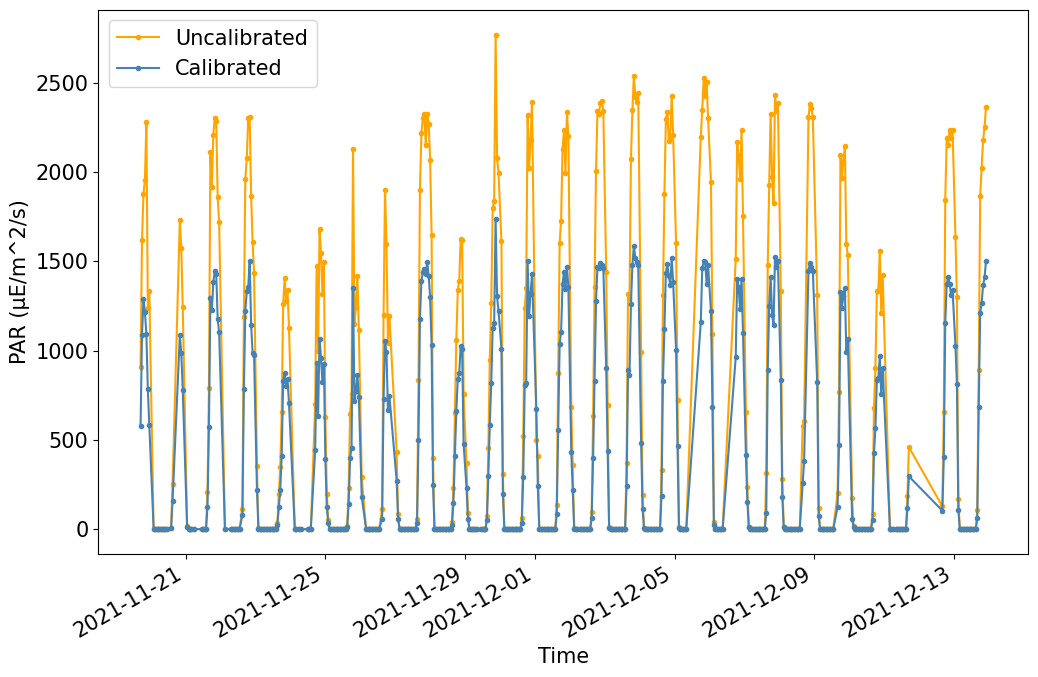

In [127]:
x = g4_data['time']
y = g4_data['sat_par']
y1 = g4_data['par']

fig, ax = plt.subplots(sharex = True, nrows = 1, ncols = 1, figsize = (12, 8))
# plots carbon quota data
ax.plot(x, y1, c='orange', marker = '.', label = 'Uncalibrated')
ax.plot(x, y, c='steelblue', marker = '.', label = 'Calibrated')
#ax.plot(x, y2, c = 'green', marker = '.', label = 'licor')

ax.set_xlabel('Time')
ax.set_ylabel('par')
ax.set_ylabel('PAR (μE/m^2/s)')
#plt.title('G4 TN397 Ship Calibrated and Uncalibrated PAR', fontsize = 15)
ax.legend(loc = 'upper left')
# sets tick marks for every day
axs.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
# formates date labels sidewayw
plt.gcf().autofmt_xdate()

for label in axs.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.rcParams.update({'font.size':15})
plt.show()

## Hyperpro depth profile 

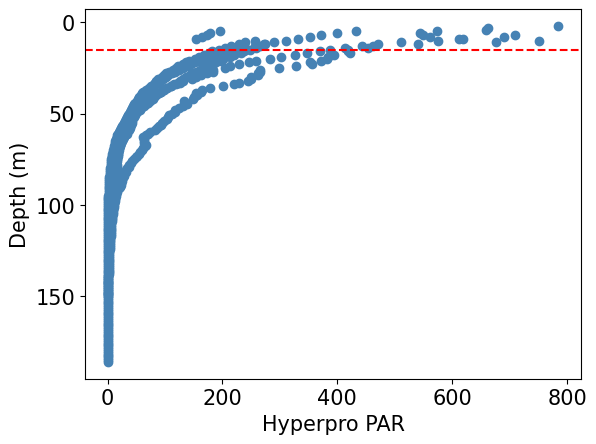

In [123]:
df = pd.read_csv('Gradients 4 - TN397 - Hyperpro Profiles.csv', usecols = ['kpar', 'flu', 'light_level', 'par_z', 'sal', 'dens', 'temp', 'time', 'lat', 'lon', 'depth'])
df['time'] = pd.DatetimeIndex(df.time.values)
df.dropna()
df1 = df.groupby([pd.Grouper(key = 'time', freq = 'H'), 'depth']).agg({'par_z': 'mean',
                                                             'temp': 'mean',
                                                             'flu': 'mean'}).reset_index()
x = df1['par_z']
y1 = df1['depth']

plt.scatter(x, y1, c = 'steelblue', label = 'PAR')

plt.axhline(y= 15, color='r', linestyle='--')

plt.rcParams.update({'font.size':15})

plt.xlabel("Hyperpro PAR")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()



plt.show()